# Libraries

In [1]:
library(tidyverse)
library(lubridate)
library(caret)
library(ranger)
library(vip)
library(rfUtilities)
library(pdp)

── Attaching packages ─────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift



Attaching package: ‘vip’


The following object is masked from ‘package:utils’:

    vi



Attaching package: ‘pdp’


The following object is masked from ‘package:purrr’:

    partial




# Load Raw Dataset
EL dataset tiene las columnas:
* Factura
* Fecha
* Customer_ID
* Sexo
* Venta ($)
* Ciudad
* Product ID

In [2]:
col_types <- cols(
    Factura = col_character(),
    Fecha = col_character(),
    Customer_ID = col_character(),
    Sexo = col_character(),
    `Venta ($)` = col_character(),
    Ciudad = col_character(),
    `Product ID` = col_integer()
)

#path = '../data/Final Project Dataset.csv'
# Pueden leer el dataset directamente desde internte o poder la ruta a su directorio local
path = 'https://www.dropbox.com/s/f3bzfsju7p1sakz/Final%20Project%20Dataset.csv?dl=1'
df_raw <- readr::read_delim(path, ',', col_types = col_types)

# Parse correct data types

In [3]:
df <- df_raw  %>% 
    rename(sale_price = 'Venta ($)',
           product_id = 'Product ID',
           sale_date = Fecha,
           invoice = Factura,
           city = Ciudad,
           sex= Sexo) %>% 
    select(-sex) %>% 
    rename_with(~ tolower(gsub(" ", "_", .x, fixed = TRUE))) %>% 
    mutate(sale_date = parse_date(sale_date, "%d/%m/%Y"),
           sale_price = str_replace(sale_price, "-", "0"),
           sale_price = str_replace(sale_price, "\\(", "-"),
           sale_price = str_replace(sale_price, "\\)", ""),
           sale_price = parse_number(sale_price,
                                     locale = locale(decimal_mark = ",", grouping_mark = "."),
                                     na = c("", "NA", "--", "-")))
head(df)

invoice,sale_date,customer_id,sale_price,city,product_id
<chr>,<date>,<chr>,<dbl>,<chr>,<int>
227837,2019-08-23,175335,2901,Rivera,4
227832,2019-08-23,140862,7256,Montevideo Periferia,19
227831,2019-08-23,225831,2901,Durazno,4
227826,2019-08-23,185845,4462,Montevideo Periferia,0
227823,2019-08-23,153566,2901,Rivera,4
227821,2019-08-23,164715,2214,Paysandú,3


# Cleanning and transformation

## missing values

In [4]:
cheack_missing <- function(df){
    t(data.frame(n_missing = sapply(df, function(x) sum(is.na(x))),
                 perc_missing = sapply(df, function(x) as.integer(mean(is.na(x))*100))))
}
cheack_missing(df)                                                             

,invoice,sale_date,customer_id,sale_price,city,product_id
n_missing,9377,0,1,0,0,0
perc_missing,14,0,0,0,0,0


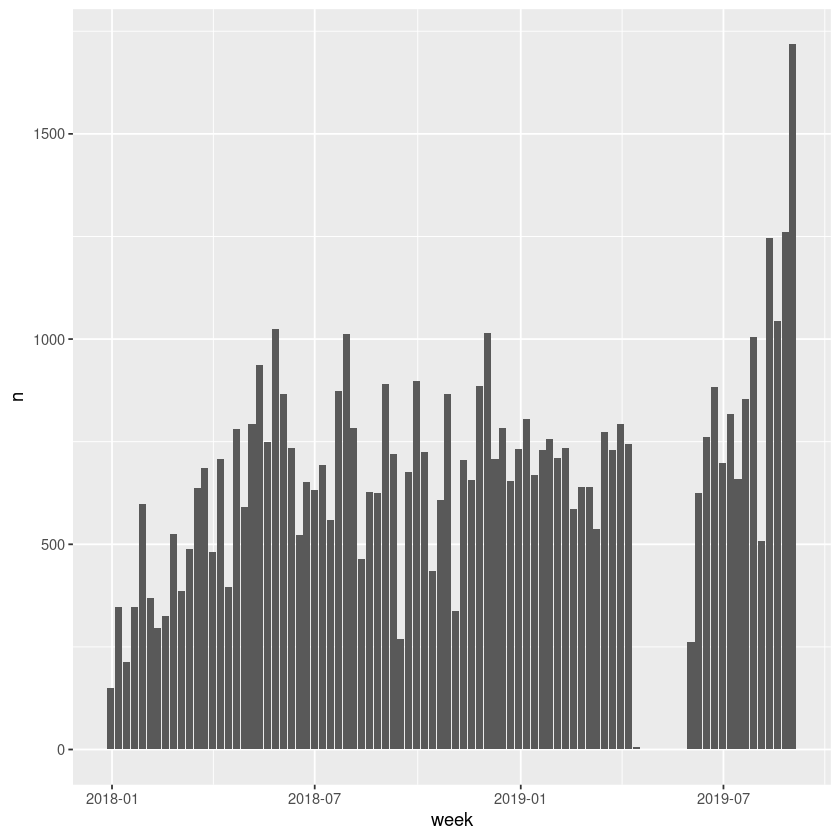

In [22]:
df %>% 
    filter(!is.na(invoice)) %>% 
    mutate(week=round_date(sale_date, "week")) %>% 
    group_by(week) %>% 
    count() %>% 
    ungroup() %>% 
    ggplot(aes(week, n)) + geom_bar(stat="identity")

## Como imputar los missing values para las facturas
* Posible estrategia seria llenar con un numero random todas las compras de un usuario en el mismo dia


In [ ]:
df <- df %>% 
    mutate(transaction_id = group_indices(., sale_date, customer_id),
           refound = ifelse(sale_price < 0, 1, 0)
          ) %>% 
    select(-invoice)


In [ ]:
head(df)

## Filtrado de las transacciones validas 

In [ ]:
df_clean <- df %>% 
    filter(!is.na(sale_price),
           !is.na(customer_id))

In [ ]:
cheack_missing(df_clean)

In [ ]:
summary(df_clean)

## Feature engineering

### Detalle de la compra

In [ ]:
resume_transaction  <- df_clean %>% 
    group_by(customer_id, transaction_id) %>% 
    summarise(sale_date=max(sale_date),
              city = max(city),
              n_prod = n(),
              n_refound = sum(refound),
              sale_total = sum(sale_price[sale_price>0]),
              refound_total = sum(sale_price[sale_price<0]),
              n_item_by_trans = n_distinct(product_id),
              is_weekend = wday(sale_price) %in% c(1,7), 
              .groups = 'drop'
             ) %>% 
    mutate(purchase_age = as.integer(max(sale_date)-sale_date),
           city = str_to_lower(str_replace_all(city, ' ', '_')))

resume_transaction[sample(1:nrow(resume_transaction), 10),]

In [ ]:
resume_transaction %>% 
    filter(n_refound>0) %>% 
    head()

### Detalles del customer

In [ ]:
resume_customer  <- resume_transaction %>% 
    group_by(customer_id) %>% 
    summarise(n_purchase = n(),  # frecuencia
              n_products = sum(n_prod),
              n_products_avg = mean(n_prod),
              last_purchase = min(purchase_age),
              customer_age = as.integer(max(sale_date)-min(sale_date)),
              n_cities = n_distinct(city),
              sale_avg = sum(sale_total)/sum(n_prod),
              item_by_trans_avg = mean(n_item_by_trans),
              ratio_week = mean(is_weekend),
              .groups = 'drop'
             ) %>% 
    arrange(n_purchase)

resume_customer[sample(1:nrow(resume_customer), 10),]

### Detalle del las ciudades de compra x usuario

In [ ]:
resume_transaction %>%
    group_by(customer_id) %>% 
    mutate(n=n()) %>% 
    group_by(city, .add = TRUE) %>% 
    summarise(n_avg = as.numeric(n()/n), .groups = 'drop') %>% 
    ungroup()  %>% 
    pivot_wider(names_from = city, values_from = n_avg, values_fn = max) %>% 
    head()

In [ ]:
resume_city = resume_transaction %>%
    group_by(customer_id) %>% 
    mutate(n=n()) %>% 
    group_by(city, .add = TRUE) %>% 
    summarise(n_avg = as.numeric(n()/n), .groups = 'drop') %>% 
    ungroup()  %>% 
    pivot_wider(
        names_from = city,
        values_from = n_avg,
        values_fn=max, 
        values_fill=0,
        names_prefix="city_",
    )
head(resume_city)

### Join Customer + Ciudad

In [ ]:
full_customer = inner_join(x=resume_customer, y=resume_city, by="customer_id")

head(full_customer)

# Definicion de Churn

In [ ]:
churn_thr <- 120
churn_raw <- full_customer %>% 
    mutate(churn = last_purchase > churn_thr,
           churn = as.integer(churn)) %>% 
    select(!c(last_purchase, customer_id))
    

--> Filtrar los usuarios con una transacción <---

In [ ]:
glimpse(churn_raw)

In [ ]:
write_csv(churn_raw, file = "churn_raw.csv")

# Split Train/Test

# EDA

# Modeling
## Base model 

In [2]:
head(warpbreaks)

,breaks,wool,tension
,<dbl>,<fct>,<fct>
1,26,A,L
2,30,A,L
3,54,A,L
4,25,A,L
5,70,A,L
6,52,A,L


tension,A,B
<fct>,<dbl>,<dbl>
L,44.55556,28.22222
M,24.00000,28.77778
H,24.55556,18.77778
